In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from tqdm import tqdm

## Read Data


In [18]:
def read_data(file_path):
    """
    Reads data from a CSV file and returns the features and labels.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        tuple: A tuple containing the features (X) and labels (y).
    """
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    # Read the CSV file
    data = pd.read_csv(file_path)

    # Check if the data is empty
    if data.empty:
        raise ValueError("The CSV file is empty.")

    return data

In [ ]:
chart_event = read_data('data/icu/_chartevents.csv')
label_event = read_data("data/hosp/_labevents.csv")
patient_basic = read_data("data/hosp/_patients.csv")
death = read_data("data/label/_label_death.csv")


## Data Preprocessing

### Get Important Data

In [ ]:
itemIds = [220045, 220210, 220052, 223762, 220179, 226730, 224639]
chart_event_filtered_data = chart_event[chart_event['itemid'].isin(itemIds)]

chart_event_filtered_data.to_csv('data/icu/_chartevents_filtered.csv', index=False)

In [ ]:
chart_events_filtered_data = read_data('data/icu/_chartevents_filtered.csv')

In [ ]:
itemIds = [51006, 50863, 50885, 50912, 50931, 51265, 51222]
label_event_filtered_data = label_event[label_event['itemid'].isin(itemIds)]
# store as csv
label_event_filtered_data.to_csv('data/icu/_labevents_filtered.csv', index=False)

In [ ]:
chart_events_filtered_data['charttime(sec)'] = pd.to_datetime(chart_events_filtered_data['charttime']).apply(lambda x: int(x.timestamp()))
label_event_filtered_data['charttime(sec)'] = pd.to_datetime(label_event_filtered_data['charttime']).apply(lambda x: int(x.timestamp()))


print(chart_events_filtered_data.head())
print(label_event_filtered_data.head())

### Merge Data

In [ ]:
groups = chart_events_filtered_data.groupby(['subject_id', "itemid"])
dict = {"subject_id":[],
        "itemid":[],
        "value": [],}

# 範例：對每群執行某個操作，例如計算每群的平均
for (a, b), group in groups:
    dict["subject_id"].append(group["subject_id"].iloc[0])
    dict["itemid"].append(group["itemid"].iloc[0])
    dict["value"].append(sum(group["value"]) / len(group["value"]))
grouped_chart_events_filtered_data = pd.DataFrame(dict)

In [ ]:
def get(values):
    x = 0
    l = 0
    for v in values:
        if v != '___':
            x += float(v)
            l += 1
    if l ==0:
        return 0
    return x/l

In [ ]:
groups = label_event_filtered_data.groupby(['subject_id', "itemid"])
dict = {"subject_id":[],
        "itemid":[],
        "value": [],}

for (a, b), group in groups:
    dict["subject_id"].append(group["subject_id"].iloc[0])
    dict["itemid"].append(group["itemid"].iloc[0])
    dict["value"].append(get(group["value"]))
grouped_label_event_filtered_data = pd.DataFrame(dict)

In [ ]:
label_event_wide = grouped_label_event_filtered_data.pivot(index='subject_id', columns='itemid', values='value')
chart_events_wide = grouped_chart_events_filtered_data.pivot(index='subject_id', columns='itemid', values='value')
patiens_data = pd.merge(label_event_wide, chart_events_wide, on='subject_id', how='outer')
print(patiens_data.head())

In [ ]:
patiens_data = pd.merge(patiens_data, patient_basic[['subject_id', 'gender', 'anchor_age']], on='subject_id', how='left')
print(patiens_data.head())

### Fill Missing Data, Encoding Categorical Data and Standardize Numeric Data

In [ ]:
patiens_data["gender"] = patiens_data["gender"].apply(lambda x: 0 if x == 'M' else 1)
print(patiens_data.head())


In [ ]:
for col in patiens_data.columns:
    if patiens_data[col].dtype in ['float64', 'int64']:  # 只處理數值欄位
        median_value = patiens_data[col].median()
        patiens_data[col] = patiens_data[col].fillna(median_value)
print(patiens_data.head())


In [ ]:
for col in patiens_data.columns:
    if col == "subject_id" or col == "gender": continue
    if patiens_data[col].dtype in ['float64', 'int64']:  # 只處理數值欄位
        mu = np.mean( patiens_data[col])
        std = np.std( patiens_data[col])
        patiens_data[col] = patiens_data[col].apply(lambda x: (x - mu)/std)
print(patiens_data.head())


In [ ]:
death_id = death["subject_id"]
patiens_data["death"] = patiens_data["subject_id"].apply(lambda x: 1 if x in death_id.values else 0)
print(patiens_data.head())
print(len(patiens_data["subject_id"]))

In [ ]:
patiens_data.to_csv("data/preprocessed_data.csv", index=False)

In [19]:
patiens_data = read_data("data/preprocessed_data.csv")
print(patiens_data.head())

   subject_id     50863     50885     50912     50931     51006     51222  \
0      100001 -0.209779 -0.188892 -0.094490  2.000875 -0.517688 -1.975948   
1      100002 -0.209779 -0.188892 -0.392939 -0.358453 -0.542447 -0.004123   
2      100003 -0.209779 -0.188892 -0.483590 -0.358453 -0.651956  1.414127   
3      100004 -0.209779 -0.188892 -0.295316 -0.358453 -0.310443 -0.118803   
4      100005 -0.428716 -0.188892 -0.178167  2.514182 -0.763370 -0.521098   

      51265    220045    220052    220179    220210    223762    224639  \
0  3.380409  0.175613 -0.036692 -0.234006 -0.873777 -0.018018 -0.095061   
1  0.188842  0.449380 -0.036692 -0.038007  0.613452 -0.018018 -0.095061   
2  0.338626  0.173795 -0.036692 -0.043335  0.895369 -0.018018 -0.095061   
3 -0.149753  0.045016 -0.036692  0.300045  1.328421 -0.018018 -0.095061   
4 -0.362866 -0.576451  0.735917 -0.156299  0.699366 -0.018018 -0.498382   

     226730  gender  anchor_age  death  
0 -0.007551       0   -0.710272      0  
1 -0

# Model

## Load Data

In [37]:
class TimeSeriesDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        feature_cols = [col for col in df.columns if col not in ['subject_id', 'death']]
        grouped = df.groupby('subject_id')

        self.inputs = []
        self.labels = []

        for subject_id, group in grouped:
            group = group.sort_index()  # 如果沒有時間欄位，可以先這樣排；有的話可改成 sort_values('time')
            features = group[feature_cols].drop(columns=['death'], errors='ignore').values.astype(np.float32)
            label = group['death'].values[0]
            self.inputs.append(torch.tensor(features, dtype=torch.float32))
            self.labels.append(torch.tensor(label, dtype=torch.float32))

        self.inputs = torch.stack(self.inputs)
        self.labels = torch.stack(self.labels)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]


In [38]:
# ======================= Models ============================
class MLP(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape[0] * input_shape[1], 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        return self.fc(h_n[-1])

class SAINT(nn.Module):
    def __init__(self, input_dim, seq_len, embed_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim * seq_len, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.flatten(1)
        return self.fc(x)

In [49]:
def train_model(model, train_loader, test_loader, device, epochs=10):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()
    train_loss, test_loss = [], []

    best_epoch = 0
    best_test_loss = float('inf')
    best_preds = None
    best_labels = None
    best_state_dict = None

    for epoch in range(epochs):
        model.train()
        total = 0
        running_loss = 0.0
        for X, y in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}"):
            X, y = X.to(device), y.to(device).unsqueeze(1)
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)
            total += X.size(0)
        train_loss.append(running_loss / total)

        model.eval()
        running_loss = 0.0
        preds_epoch = []
        labels_epoch = []
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device).unsqueeze(1)
                pred = model(X)
                loss = criterion(pred, y)
                running_loss += loss.item() * X.size(0)
                preds_epoch.extend(pred.cpu().numpy())
                labels_epoch.extend(y.cpu().numpy())
        epoch_test_loss = running_loss / len(test_loader.dataset)
        test_loss.append(epoch_test_loss)

        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            best_epoch = epoch
            best_preds = np.array(preds_epoch).flatten()
            best_labels = np.array(labels_epoch).flatten()
            best_state_dict = model.state_dict()

    model.load_state_dict(best_state_dict)
    return best_epoch, train_loss, test_loss, best_preds, best_labels


# ----------------- Evaluation Function -----------------
def evaluate(preds, labels):
    preds_bin = (preds >= 0.5).astype(int)
    return {
        "AUC": roc_auc_score(labels, preds),
        "F1": f1_score(labels, preds_bin),
        "Precision": precision_score(labels, preds_bin),
        "Recall": recall_score(labels, preds_bin)
    }

## MLP

In [40]:
csv_path = "data/preprocessed_data.csv"  # 請換成你的實際路徑
dataset = TimeSeriesDataset(csv_path)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

input_shape = dataset[0][0].shape
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### No Time Line

In [57]:
from sklearn.model_selection import train_test_split

def evaluate(preds, labels):
    preds_bin = (preds >= 0.5).astype(int)
    result = {}

    if len(np.unique(labels)) < 2:
        result["AUC"] = float("nan")
    else:
        result["AUC"] = roc_auc_score(labels, preds)

    result["F1"] = f1_score(labels, preds_bin)
    result["Precision"] = precision_score(labels, preds_bin, zero_division=0)
    result["Recall"] = recall_score(labels, preds_bin, zero_division=0)

    return result

def main():
    csv_path = "data/preprocessed_data.csv"  # ← 你自己的 CSV 檔路徑
    dataset = TimeSeriesDataset(csv_path)
    input_shape = dataset[0][0].shape

    # 取得標籤，用於 stratify split
    labels = [int(dataset[i][1]) for i in range(len(dataset))]
    indices = list(range(len(dataset)))

    train_idx, test_idx = train_test_split(
        indices,
        test_size=0.2,
        stratify=labels,
        random_state=42
    )

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    test_dataset = torch.utils.data.Subset(dataset, test_idx)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"✅ Using device: {device}")

    models = {
        "MLP": MLP(input_shape),
        "RNN": RNNModel(input_size=input_shape[1]),
        "SAINT": SAINT(input_dim=input_shape[1], seq_len=input_shape[0])
    }

    history = {}
    metrics = {}
    best_epochs = {}
    for name, model in models.items():
        print(f"\n🚀 Training {name}")
        best_epoch, train_loss, test_loss, preds, labels = train_model(model, train_loader, test_loader, device, 50)
        result = evaluate(preds, labels)
        history[name] = (train_loss, test_loss)
        metrics[name] = result
        best_epochs[name] = best_epoch

    # Plot losses
    plt.figure(figsize=(10, 6))
    for name, (tr, te) in history.items():
        plt.plot(tr, label=f'{name} Train')
        plt.plot(te, label=f'{name} Test')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Test Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_comparison.png")
    print("📊 Saved: loss_comparison.png")

    # Print metrics
    df_metrics = pd.DataFrame(metrics).T
    print("\n📈 Evaluation Metrics:")
    print(df_metrics.round(4))
    df_metrics.to_csv("model_metrics.csv")
    print("📁 Saved: model_metrics.csv")
    print(best_epochs)


c:\Users\lin07\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


✅ Using device: cuda

🚀 Training MLP


[Train] Epoch 50: 100%|██████████| 217/217 [00:00<00:00, 573.58it/s]



🚀 Training RNN


[Train] Epoch 50: 100%|██████████| 217/217 [00:00<00:00, 447.40it/s]



🚀 Training SAINT


[Train] Epoch 50: 100%|██████████| 217/217 [00:01<00:00, 183.00it/s]


📊 Saved: loss_comparison.png

📈 Evaluation Metrics:
          AUC      F1  Precision  Recall
MLP    0.8132  0.4655     0.6575  0.3603
RNN    0.8285  0.4657     0.6825  0.3534
SAINT  0.8286  0.4870     0.7076  0.3712
📁 Saved: model_metrics.csv
{'MLP': 7, 'RNN': 29, 'SAINT': 22}


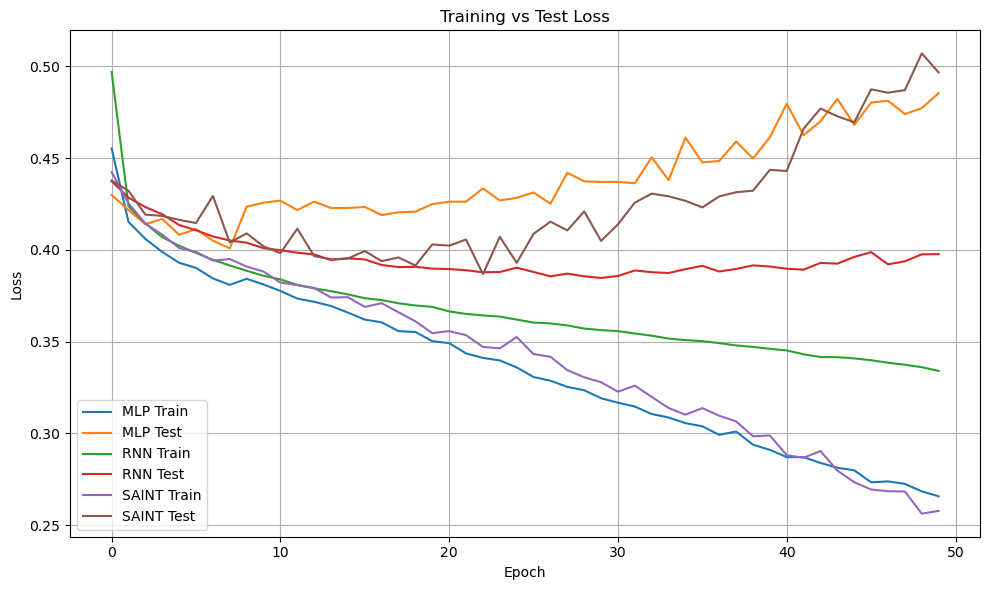

In [58]:
main()